# Exploring the Android App Market - A Data Mining Analysis of Google Playstore Applications 



SENG 474 Fall 2018 Data Mining Project<br>
Cole Boothman St.ID V00808231 <br>
Amy Hanvoravongchai V00822271 <br>

Using the Naive Bayes text classification algorithm, an analysis of user reviews was made based on the sentiment rating given to each review. 
<br>
This data file contains the first 'most relevant' 100 reviews for each app. Each review text or comment has been pre-processed and attributed with 3 new features: Sentiment, Sentiment Polarity and Sentiment Subjectivity.
The user reviews data for application of the Google Playstore has a total of 37427 entries.

The first thing we need to do is load our data file. The data is in CSV format without a header line or any quotes. We can open the file with the open function and read the data lines using the reader function in the CSV module.

In [1]:
import pandas as pd
import random
import re

# Read the data from a file
data = pd.read_csv('googleplaystore_user_reviews.csv', encoding = "ISO-8859-1")
data = data.iloc[:, 1:]
data.head()

,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,NaN,NaN,NaN,NaN
3,Works great especially going grocery store,Positive,0.40,0.875000
4,Best idea us,Positive,1.00,0.300000


In [2]:
data = data[pd.notnull(data['Translated_Review'])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 4 columns):
Translated_Review         37427 non-null object
Sentiment                 37427 non-null object
Sentiment_Polarity        37427 non-null float64
Sentiment_Subjectivity    37427 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.4+ MB


In the figure below, is a graphic for the reviews grouped by their sentiment value. Positive value seems to be highest, by far, and neutral as lowest. 

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('Sentiment').Translated_Review.count().plot.barh(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

We want to convert obtained dataframe into list. It filters out irrelevant columns not used in this document. We are ignoring capitalizations and NaNs.
<br> 
Corresponding sentiment values as integers:
<br>
<ul>
    <li> 'Positive' as 0 </li>
    <li> 'Neutral' as 1 </li>
    <li> 'Negative' as 2 </li>
</ul>

In [4]:
def get_data(data):

    #change dataframe to lists
    reviews = data.iloc[:,0].dropna().tolist()
    sentiment = data.iloc[:,1].dropna().tolist()
    
    #changing sentiment ()list values to int values
    for index, item in enumerate(sentiment):
        if item == 'Positive':
            sentiment[index] = 0
        elif item == 'Neutral':
            sentiment[index] = 1
        else:
            sentiment[index] = 2
    return reviews, sentiment

The training model <br>


In [20]:
model = {}
from nltk.corpus import stopwords 

def train_model(data, sentiment):
    stop_words = set(stopwords.words('english'))
    sum_words_positive = 0
    sum_words_negative = 0
    sum_words_neutral = 0
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    reviews = [[y.lower() for y in x.split()]for x in data] 
    for i, review in enumerate(reviews):
        reviews[i] = [word for word in review if word not in stop_words]
    count_of_words = {}         
    for i, sentence in enumerate(reviews):
        for word in sentence:
            word = re.sub(r'[^a-z]', '', word)
            if word not in model:
                model[word] = [0, 0, 0] 
            #already encountered word
            model[word][sentiment[i]] += 1
            if word not in count_of_words:
                count_of_words[word] = 1
            else:
                count_of_words[word] += 1

        for word, count in count_of_words.items():
            if count < 25 and word in model:
                model.pop(word)
        if sentiment[i] == 0:
            sum_words_positive += len(sentence)
            positive_count += 1
        elif sentiment[i] == 1:
            sum_words_neutral += len(sentence)
            neutral_count += 1
        elif sentiment[i] == 2:
            sum_words_negative += len(sentence)
            negative_count += 1
        else:
            continue
    
    return model, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral

In [21]:
#split dataframe frame up for train/test randomly of 80% and 20% sets, respectively
train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)
    
train_data, train_sentiment = get_data(train_data)
train_model_dict, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral = train_model(train_data,train_sentiment)
test_data, test_sentiment = get_data(test_data)

Probabilities: 
Positive: 0.6411395364371117
Neutral: 0.1381003272994456
Negative:  0.22076013626344265


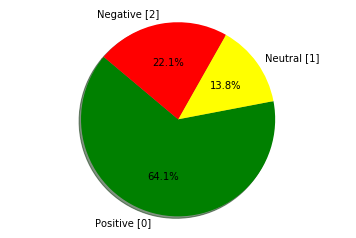

In [22]:
total = positive_count + negative_count + neutral_count
probability_positive = positive_count/total
probability_negative = negative_count/total
probability_neutral = neutral_count/total

print ("Probabilities: \n" + "Positive: " + str(probability_positive) + "\nNeutral: "+ str(probability_neutral) + "\nNegative:  " + str(probability_negative))

# Data to plot
labels = 'Positive [0]', 'Neutral [1]', 'Negative [2]'
sizes = [probability_positive, probability_neutral, probability_negative]
colors = ['green', 'yellow', 'red']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [23]:

def calc_cond_probabilities(train_model_dict, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral):
    cond_probabilities = {}

    for word in model:
      
        if word not in cond_probabilities:
            cond_probabilities[word] = [0, 0, 0]

        #calculate conditional probabilities P(word|wise) & P(word|prediction)
        cond_probabilities[word][0] = (model[word][0] + 1)/(sum_words_positive + len(model))
        cond_probabilities[word][1] = (model[word][1] + 1)/(sum_words_neutral + len(model))
        cond_probabilities[word][2] = (model[word][2] + 1)/(sum_words_negative + len(model))

    return cond_probabilities

conditional_probabilities = {}
conditional_probabilities = calc_cond_probabilities(train_model_dict, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral)
print (conditional_probabilities)

{'': [0.02400757840772948, 0.02733238407726119, 0.027471295472996482], 'im': [0.004634344922807354, 0.0033739862564229556, 0.005149418177600804], 'so': [0.0004210226516378091, 0.0004333560329350585, 0.00045617968840607723], 'it': [0.006188413828117503, 0.0056026744258032566, 0.005334982796613446], 'go': [0.002563284967324308, 0.0023215501764378135, 0.0025515135114238217], 'de': [1.5478773957272392e-05, 9.286200705751254e-05, 7.731859125526733e-06], 'ok': [0.001235206161790337, 0.00024763201882003344, 0.00041752039277844356], 'sc': [2.476603833163583e-05, 6.190800470500836e-05, 7.731859125526733e-06], 'ik': [6.191509582908957e-06, 3.095400235250418e-05, 7.731859125526733e-06], 'us': [0.0009813542688910696, 0.0009595740729276296, 0.0008505045038079407], 'u': [0.001371419372614334, 0.0018262861387977466, 0.0021571886960219584], 'st': [0.00013621321082399706, 0.00024763201882003344, 0.00017010090076158814], 'to': [0.0004612674639267173, 0.00040240203058255434, 0.00034020180152317627], 'n':

In [24]:
def classify_test_data(words, probablility_positive, probablility_negative, probablility_neutral, conditional_probabilities):
    temp_positive = 1
    temp_negative = 1
    temp_neutral = 1
    for word in words:
        if word in model:
            temp_positive *= conditional_probabilities[word][0]
            temp_neutral *= conditional_probabilities[word][1]
            temp_negative *= conditional_probabilities[word][2]

    temp_positive *= probability_positive
    temp_negative *= probability_negative
    temp_neutral *= probability_neutral

    if (temp_positive > temp_negative) and (temp_positive > temp_neutral):
        value = temp_positive
        return 0
    elif (temp_neutral > temp_positive) and (temp_neutral > temp_negative):
        value = temp_neutral
        return 1
    else:
        value = temp_negative
        return 2

result = []
for i, element in enumerate(test_data):
    words = element.split(' ')
    result.append(classify_test_data(words, probability_positive, probability_negative, probability_neutral, conditional_probabilities))
#     print (element + "\n"  )


In [25]:
correct = 0
incorrect = 0

for i, j in zip(result, test_sentiment):

    if i == j:
        correct += 1
    else:
        incorrect += 1

print("Accuracy: " + str((correct/len(test_sentiment))*100))

Accuracy: 70.35404141616567
